In [1]:
%pylab inline
import cv2 as cv
import numpy as np
import argparse

Populating the interactive namespace from numpy and matplotlib


In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets 

In [4]:
#     # window size is WxW
# C_Thr = 0.43    # threshold for coherency
# LowThr = 35     # threshold1 for orientation, it ranges from 0 to 180
# HighThr = 57    # threshold2 for orientation, it ranges from 0 to 180

# from
def calcGST(inputIMG, w):
    """
    from https://docs.opencv.org/4.2.0/d4/d70/tutorial_anisotropic_image_segmentation_by_a_gst.html
    :param inputIMG:
    :param w:
    :return:
    """
    img = inputIMG.astype(np.float32)
    # GST components calculation (start)
    # J =  (J11 J12; J12 J22) - GST
    img_diff_x = cv.Sobel(img, cv.CV_32F, 1, 0, 3) #Calculates the first image derivatives using an extended Sobel operator
    img_diff_y = cv.Sobel(img, cv.CV_32F, 0, 1, 3)
    img_diff_xy = cv.multiply(img_diff_x, img_diff_y)

    img_diff_xx = cv.multiply(img_diff_x, img_diff_x)
    img_diff_yy = cv.multiply(img_diff_y, img_diff_y)
    J11 = cv.boxFilter(img_diff_xx, cv.CV_32F, (w, w))
    J22 = cv.boxFilter(img_diff_yy, cv.CV_32F, (w, w))
    J12 = cv.boxFilter(img_diff_xy, cv.CV_32F, (w, w))
    # GST components calculations (stop)
    # eigenvalue calculation (start)
    # lambda1 = J11 + J22 + sqrt((J11-J22)^2 + 4*J12^2)
    # lambda2 = J11 + J22 - sqrt((J11-J22)^2 + 4*J12^2)
    tmp1 = J11 + J22
    tmp2 = J11 - J22
    tmp2 = cv.multiply(tmp2, tmp2)
    tmp3 = cv.multiply(J12, J12)
    tmp4 = np.sqrt(tmp2 + 4.0 * tmp3)
    lambda1 = tmp1 + tmp4  # biggest eigenvalue
    lambda2 = tmp1 - tmp4  # smallest eigenvalue
    # eigenvalue calculation (stop)
    # Coherency calculation (start)
    # Coherency = (lambda1 - lambda2)/(lambda1 + lambda2)) - measure of anisotropism
    # Coherency is anisotropy degree (consistency of local orientation)
    coherency = cv.divide(lambda1 - lambda2, lambda1 + lambda2)
    # Coherency calculation (stop)
    # orientation angle calculation (start)
    # tan(2*Alpha) = 2*J12/(J22 - J11)
    # Alpha = 0.5 atan2(2*J12/(J22 - J11))
    orientation = cv.phase(J22 - J11, 2.0 * J12, angleInDegrees=True)
    orientation = 0.5 * orientation
    # orientation angle calculation (stop)
    return coherency, orientation

In [5]:
imgIn_pre = cv.imread("sharad_data/s_00429402_thm.jpg", cv.IMREAD_GRAYSCALE)
#imgIn_pre = cv.imread("sharad_data/s_00387302_thm.jpg", cv.IMREAD_GRAYSCALE)

imgIn = cv.fastNlMeansDenoising(imgIn_pre,None,22,7,21)
imgInSquare = imgIn[1600:3600,2900:4900]
imgInTiny = imgIn[1700:3400,2600:5000]

W = 10

imgCoherency, ori = calcGST(imgInTiny, W)
imgCoherencySquare, oriSquare = calcGST(imgInSquare, W)

ori[ori>=90] -=180

_, imgCoherencyBin = cv.threshold(imgCoherency,0.1, 255, cv.THRESH_BINARY) #2nd value: C_Thr
_, imgCoherencyBinSquare = cv.threshold(imgCoherencySquare,0.1, 255, cv.THRESH_BINARY) 

ori_bin = cv.inRange(ori, -50, 50)
ori_binSquare = cv.inRange(oriSquare, -50, 50)

imgBin = cv.bitwise_and(imgCoherencyBin, ori_bin.astype(np.float32))
imgBinSquare = cv.bitwise_and(imgCoherencyBinSquare, ori_binSquare.astype(np.float32))

In [6]:
dilation_size = 5
element = cv.getStructuringElement( cv.MORPH_ELLIPSE,
                                       ( 2*dilation_size + 1, 2*dilation_size+1 ),
                                       ( dilation_size, dilation_size ) );

In [7]:
eroded = cv.erode(imgBin, element)
imgBin = cv.dilate(eroded, element)

In [8]:
#res = np.uint8(0.5*(imgIn + imgBin))
resTiny = np.uint8(0.5*(imgInTiny + imgBin))
edges = cv.Canny(imgInTiny,50,100) #2nd,3rd: lower and upper threshold

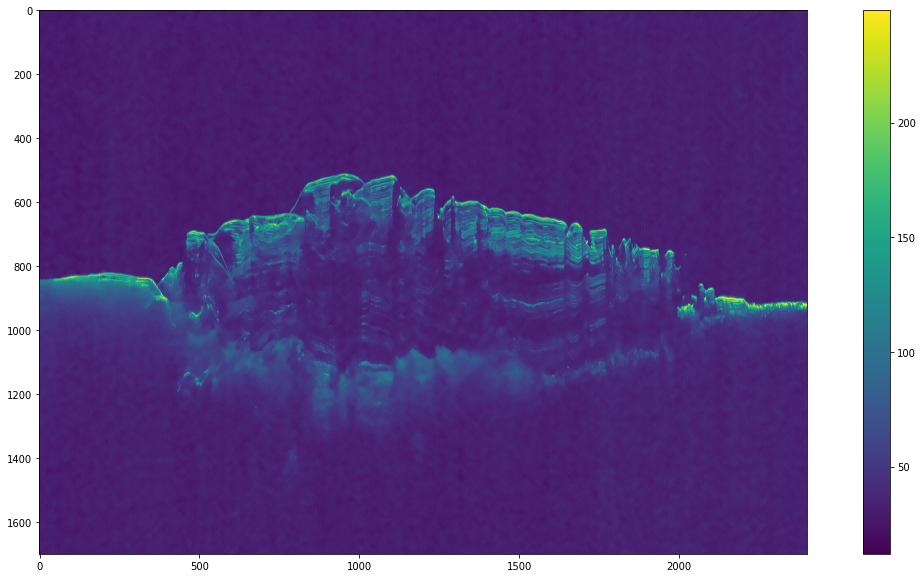

In [9]:
figure(figsize=(20,10))

imshow(imgInTiny)
colorbar()

385


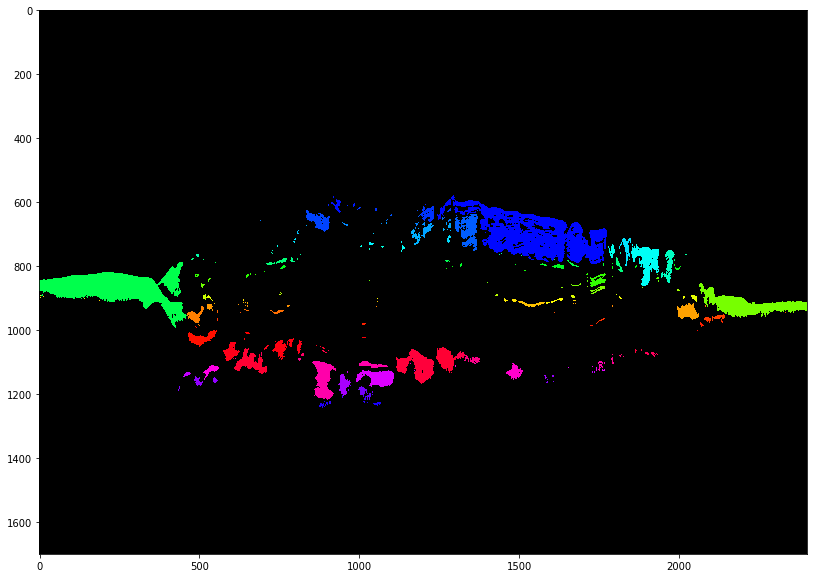

In [10]:
img = cv.threshold(imgInTiny, 70, 255, cv.THRESH_BINARY)[1]  # ensure binary

num_labels, labels_im = cv.connectedComponents(img)
print(num_labels)

def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels)) #each label gets a different hue
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv.merge([label_hue, blank_ch, blank_ch]) #each element of the output array will be a concatenation of the elements of the input arrays

    # cvt to BGR for display
    labeled_img = cv.cvtColor(labeled_img, cv.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    return labeled_img

    #cv.imshow('labeled.png', labeled_img)
    #cv.waitKey()

figure(figsize=(20,10))
a = imshow_components(labels_im)
imshow(a)

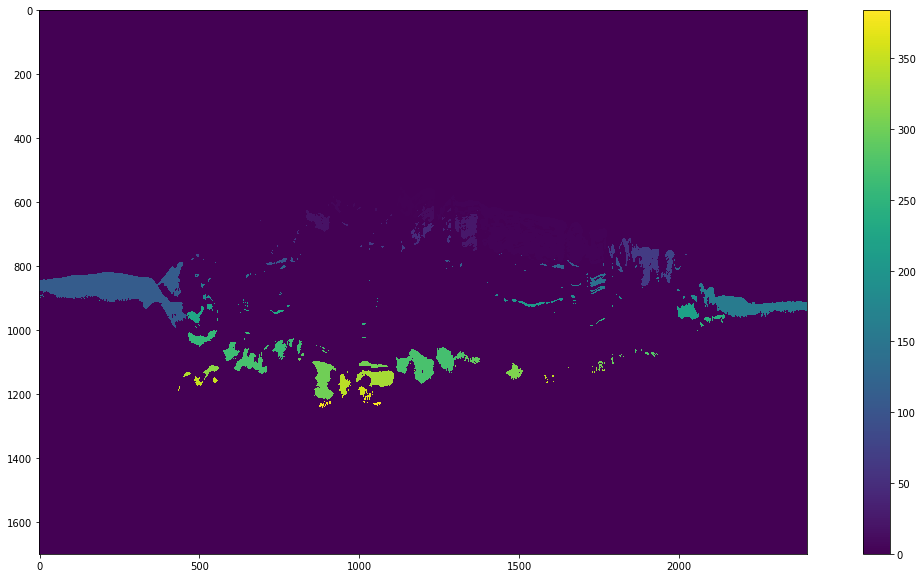

In [11]:
figure(figsize=(20,10))
imshow(labels_im)
colorbar()

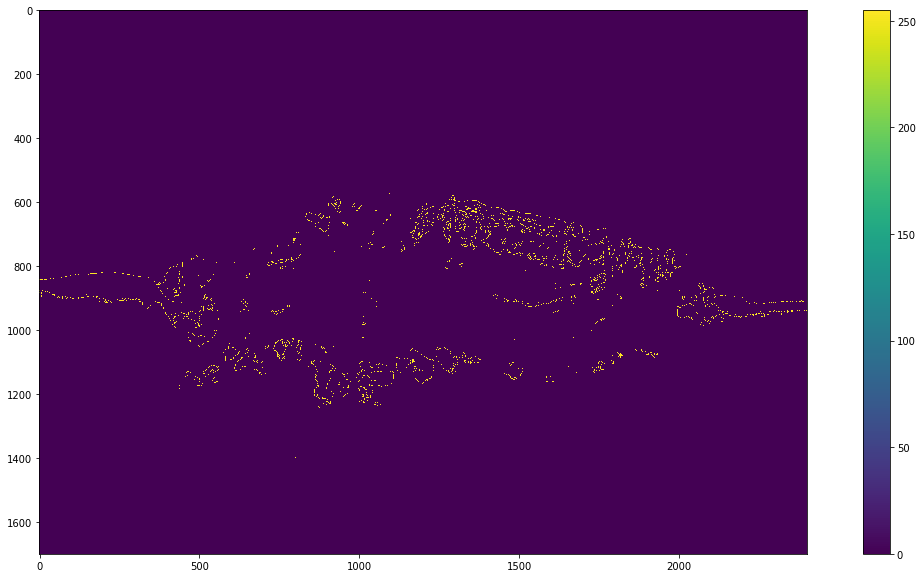

In [12]:
cannylab = cv.Canny(a,50,100)
figure(figsize=(20,10))
imshow(cannylab)
colorbar()

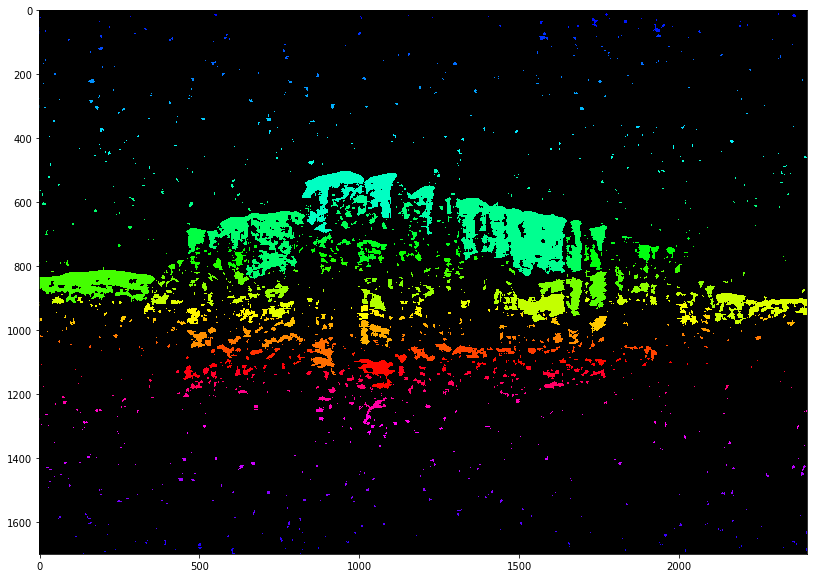

In [13]:
def connected_components_for_binaryimg(img):
    num_labels, labels = cv.connectedComponents(img)
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    #print (blank_ch)
    labeled_img = cv.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv.cvtColor(labeled_img, cv.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    figure(figsize=(20,10))
    imshow(labeled_img)


ori_conncomp = connected_components_for_binaryimg(ori_bin)    

# Selection of bigger components

In [14]:
def equallabels(labels_im, number):
    numlist=[]
    for i in range(labels_im.shape[0]):
        for j in range(labels_im.shape[1]):
            if labels_im[i][j] == number:
                numlist.append(labels_im[i][j])
            else:
                pass
    return len(numlist)
            
equallabels(labels_im,1)

#equal to find 5° column of cv.connectedComponentsWithStats for a specific row (number)

47804

In [15]:
def concompmean(image,thr):
    lens=[]
    img = cv.threshold(image, thr, 255, cv.THRESH_BINARY)[1]
    num_labels, labels_im = cv.connectedComponents(img)
    for k in range(num_labels):
        newlen = equallabels(labels_im, k)
        lens.append(newlen)
    print (lens)
    return (np.mean(lens))

#returns np.mean(stats[:,4])

In [16]:
#select connected components with pixel area > certain value (valuemean)

def selection(img):
    num_labels, labels_im, stats, centroids = cv.connectedComponentsWithStats(img)
    #print (stats.shape)

    #n° stats rows: n° of connected components
    #5° column stats: number of pixel of that connected component
    #other stats columns describe the box thar contains each component

    areas = stats[:,4]
    areas1 = areas.tolist()
    valuemean = np.mean(areas1)
    print ('Total number of connected components:', len(areas1))
    print ('Average area of connected components:', valuemean)

    bigareasindex = []
    bigareas = []

    for i in areas1:
        if i>=valuemean:
            bigareasindex.append(areas1.index(i))
            bigareas.append(i)

    print ('Labels of connected components with pixel area higher than average:', bigareasindex)  #index 0 : background
    print ('Number of pixels of each selected area:', bigareas) 
    print('')

    bigareasarray = np.array([bigareasindex, bigareas]).T
    print (bigareasarray)
    return bigareasindex, bigareas, bigareasarray

index, areas, arearray = selection(img)

Total number of connected components: 385
Average area of connected components: 10597.402597402597
Labels of connected components with pixel area higher than average: [0, 1, 4, 111, 160]
Number of pixels of each selected area: [3863043, 47804, 44497, 34994, 13090]

[[      0 3863043]
 [      1   47804]
 [      4   44497]
 [    111   34994]
 [    160   13090]]


New label for 0 component: 0
New label for 1 component: 51
New label for 4 component: 102
New label for 111 component: 153
New label for 160 component: 204


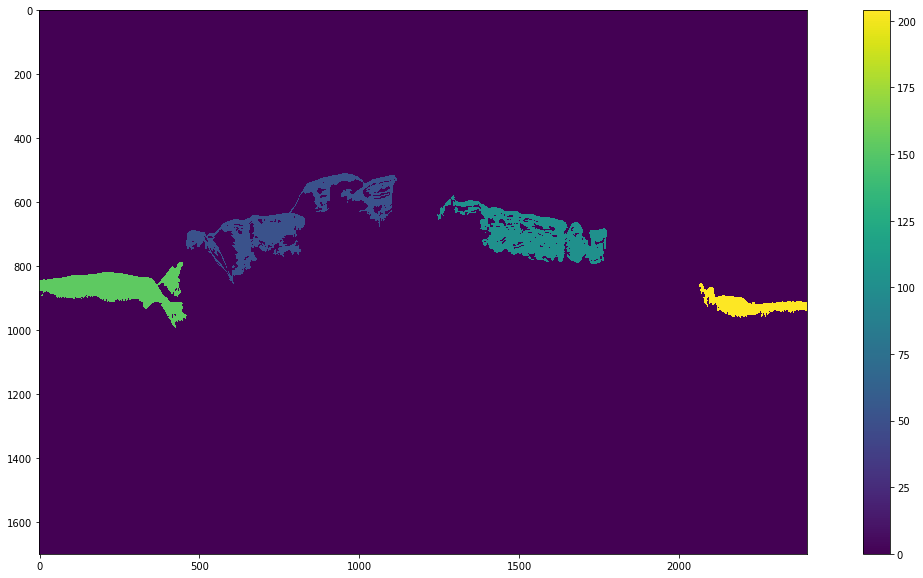

In [17]:
#new array image with only the components having area[pixel]> average area of all components

def newimgbigcomponents(img,bigareasindex):
    new= np.zeros_like(img,dtype='int32')
    num_labels, labels_im = cv.connectedComponents(img)
    hue = range(0, 255, int(255/len(bigareasindex)))     #set new colors for the selected components in range(0,255)
    for i in range(len(bigareasindex)):       
        #new += np.where(labels_im == bigareasindex[i], labels_im, 0)  #gives problems showing components with label>255
        new += np.where(labels_im == bigareasindex[i], hue[i], 0)    #selected components are mantained with a new label in range(0,255)
        print ('New label for', bigareasindex[i], 'component:', hue[i])
    return new, hue

newimg, huenewimg = newimgbigcomponents(img,index)

figure(figsize=(20,10))
imshow(newimg)
colorbar()

#imsave('conncomp_selection.png',newimg,vmin=newimg.min(), vmax=newimg.max())

In [18]:
import imageio
newimg_uint8 = np.uint8(179*newimg/np.max(newimg))
imageio.imwrite('conncomp_selection.png', newimg_uint8)

print(newimg_uint8.dtype)

uint8


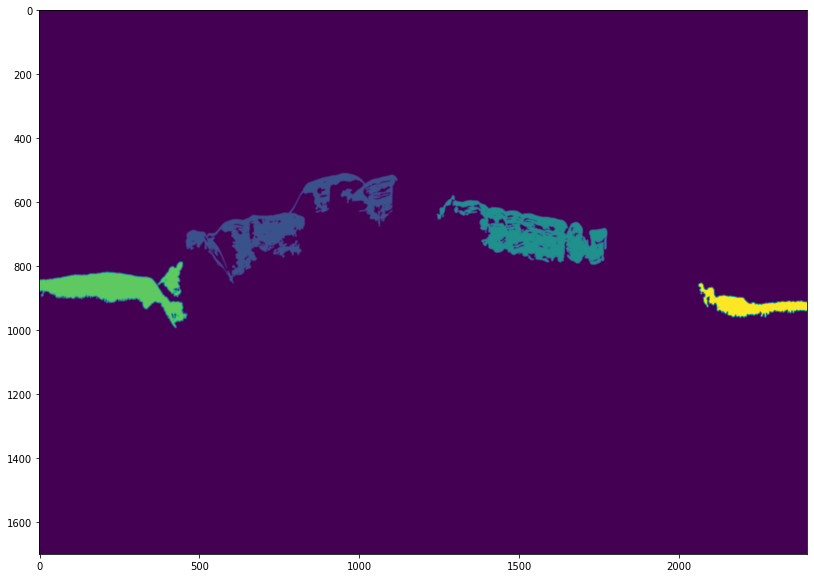

In [19]:
#with edges
figure(figsize=(20,10))
imshow(newimg,interpolation='bicubic')
#imshow(newimg,interpolation='spline16')
#imshow(newimg,interpolation='spline36')

In [20]:
indexoribin, areasoribin, arrayoribin = selection(ori_bin)

Total number of connected components: 2567
Average area of connected components: 1589.4039735099338
Labels of connected components with pixel area higher than average: [0, 541, 544, 583, 621, 685, 715, 728, 748, 807, 982, 1016, 1062, 1082, 1120, 1173, 1198, 1207, 1244, 1259, 1280, 1381, 1442, 1481, 1500, 1546, 1606, 1710]
Number of pixels of each selected area: [3772196, 13717, 7963, 4682, 47220, 25671, 5029, 2424, 2972, 2607, 21521, 4726, 3606, 2374, 1965, 2432, 9354, 5103, 5963, 2044, 1660, 1600, 1899, 1769, 1791, 4041, 2327, 4707]

[[      0 3772196]
 [    541   13717]
 [    544    7963]
 [    583    4682]
 [    621   47220]
 [    685   25671]
 [    715    5029]
 [    728    2424]
 [    748    2972]
 [    807    2607]
 [    982   21521]
 [   1016    4726]
 [   1062    3606]
 [   1082    2374]
 [   1120    1965]
 [   1173    2432]
 [   1198    9354]
 [   1207    5103]
 [   1244    5963]
 [   1259    2044]
 [   1280    1660]
 [   1381    1600]
 [   1442    1899]
 [   1481    1769]
 [ 

New label for 0 component: 0
New label for 541 component: 9
New label for 544 component: 18
New label for 583 component: 27
New label for 621 component: 36
New label for 685 component: 45
New label for 715 component: 54
New label for 728 component: 63
New label for 748 component: 72
New label for 807 component: 81
New label for 982 component: 90
New label for 1016 component: 99
New label for 1062 component: 108
New label for 1082 component: 117
New label for 1120 component: 126
New label for 1173 component: 135
New label for 1198 component: 144
New label for 1207 component: 153
New label for 1244 component: 162
New label for 1259 component: 171
New label for 1280 component: 180
New label for 1381 component: 189
New label for 1442 component: 198
New label for 1481 component: 207
New label for 1500 component: 216
New label for 1546 component: 225
New label for 1606 component: 234
New label for 1710 component: 243


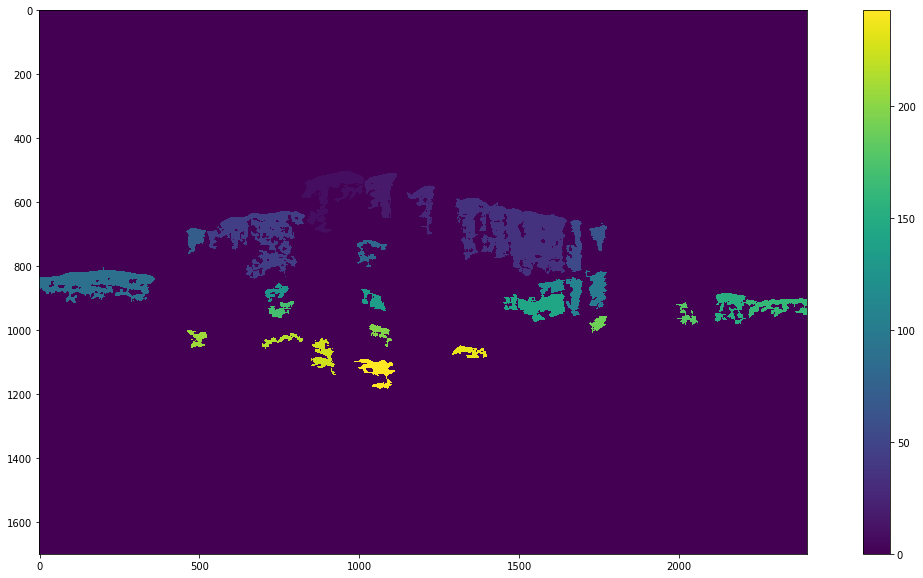

In [21]:
figure(figsize=(20,10))
imshow(newimgbigcomponents(ori_bin,indexoribin)[0])
colorbar()

# Interactive

In [22]:
def threshold(img, thr):
    img = cv.threshold(img, thr, 255, cv.THRESH_BINARY)[1]
    figure(figsize=(20,10))
    imshow(img)

interact(threshold, img=fixed(imgInTiny), thr=(0,255))

interactive(children=(IntSlider(value=127, description='thr', max=255), Output()), _dom_classes=('widget-inter…

<function __main__.threshold(img, thr)>

In [23]:
def connected_components(img, thr):
    img = cv.threshold(img, thr, 255, cv.THRESH_BINARY)[1]  # ensure binary
    num_labels, labels = cv.connectedComponents(img)
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    #print (blank_ch)
    labeled_img = cv.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv.cvtColor(labeled_img, cv.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    figure(figsize=(20,10))
    imshow(labeled_img)

interact(connected_components, img=fixed(imgInTiny), thr=(0,255))

interactive(children=(IntSlider(value=127, description='thr', max=255), Output()), _dom_classes=('widget-inter…

<function __main__.connected_components(img, thr)>

# Finding edges

In [24]:
#finding upper edge 

edges = np.zeros_like(newimg)
upperlimitx = []
upperlimity = []
for i in range(newimg.shape[1]):
    column = newimg[:,i]
    colist = column.tolist()
    for j in huenewimg[1:]: 
        try:
            print ('column', i, 'upper edge at:', colist.index(j), ', with label:', j) 
            #if in the i-column, pixels with label equal to one of the selected components are present, 
            #it finds the index (row) of the first one with that label
            edges[colist.index(j)][i] = j
            upperlimitx.append(colist.index(j))
            upperlimity.append(i)
        except ValueError:
            pass


column 0 upper edge at: 843 , with label: 153
column 1 upper edge at: 843 , with label: 153
column 2 upper edge at: 843 , with label: 153
column 3 upper edge at: 843 , with label: 153
column 4 upper edge at: 843 , with label: 153
column 5 upper edge at: 842 , with label: 153
column 6 upper edge at: 843 , with label: 153
column 7 upper edge at: 843 , with label: 153
column 8 upper edge at: 843 , with label: 153
column 9 upper edge at: 843 , with label: 153
column 10 upper edge at: 843 , with label: 153
column 11 upper edge at: 842 , with label: 153
column 12 upper edge at: 842 , with label: 153
column 13 upper edge at: 842 , with label: 153
column 14 upper edge at: 842 , with label: 153
column 15 upper edge at: 842 , with label: 153
column 16 upper edge at: 842 , with label: 153
column 17 upper edge at: 842 , with label: 153
column 18 upper edge at: 843 , with label: 153
column 19 upper edge at: 843 , with label: 153
column 20 upper edge at: 843 , with label: 153
column 21 upper edge at

column 294 upper edge at: 830 , with label: 153
column 295 upper edge at: 830 , with label: 153
column 296 upper edge at: 830 , with label: 153
column 297 upper edge at: 831 , with label: 153
column 298 upper edge at: 831 , with label: 153
column 299 upper edge at: 831 , with label: 153
column 300 upper edge at: 831 , with label: 153
column 301 upper edge at: 831 , with label: 153
column 302 upper edge at: 832 , with label: 153
column 303 upper edge at: 832 , with label: 153
column 304 upper edge at: 832 , with label: 153
column 305 upper edge at: 832 , with label: 153
column 306 upper edge at: 832 , with label: 153
column 307 upper edge at: 832 , with label: 153
column 308 upper edge at: 832 , with label: 153
column 309 upper edge at: 833 , with label: 153
column 310 upper edge at: 833 , with label: 153
column 311 upper edge at: 833 , with label: 153
column 312 upper edge at: 833 , with label: 153
column 313 upper edge at: 833 , with label: 153
column 314 upper edge at: 833 , with lab

column 507 upper edge at: 693 , with label: 51
column 508 upper edge at: 693 , with label: 51
column 509 upper edge at: 693 , with label: 51
column 510 upper edge at: 693 , with label: 51
column 511 upper edge at: 693 , with label: 51
column 512 upper edge at: 693 , with label: 51
column 513 upper edge at: 693 , with label: 51
column 514 upper edge at: 693 , with label: 51
column 515 upper edge at: 694 , with label: 51
column 516 upper edge at: 694 , with label: 51
column 517 upper edge at: 695 , with label: 51
column 518 upper edge at: 696 , with label: 51
column 519 upper edge at: 698 , with label: 51
column 520 upper edge at: 700 , with label: 51
column 521 upper edge at: 701 , with label: 51
column 522 upper edge at: 703 , with label: 51
column 523 upper edge at: 705 , with label: 51
column 524 upper edge at: 706 , with label: 51
column 525 upper edge at: 706 , with label: 51
column 526 upper edge at: 702 , with label: 51
column 527 upper edge at: 700 , with label: 51
column 528 up

column 845 upper edge at: 538 , with label: 51
column 846 upper edge at: 538 , with label: 51
column 847 upper edge at: 538 , with label: 51
column 848 upper edge at: 537 , with label: 51
column 849 upper edge at: 537 , with label: 51
column 850 upper edge at: 537 , with label: 51
column 851 upper edge at: 536 , with label: 51
column 852 upper edge at: 536 , with label: 51
column 853 upper edge at: 536 , with label: 51
column 854 upper edge at: 535 , with label: 51
column 855 upper edge at: 535 , with label: 51
column 856 upper edge at: 535 , with label: 51
column 857 upper edge at: 534 , with label: 51
column 858 upper edge at: 534 , with label: 51
column 859 upper edge at: 534 , with label: 51
column 860 upper edge at: 533 , with label: 51
column 861 upper edge at: 533 , with label: 51
column 862 upper edge at: 532 , with label: 51
column 863 upper edge at: 532 , with label: 51
column 864 upper edge at: 532 , with label: 51
column 865 upper edge at: 531 , with label: 51
column 866 up

column 1108 upper edge at: 516 , with label: 51
column 1109 upper edge at: 517 , with label: 51
column 1110 upper edge at: 517 , with label: 51
column 1111 upper edge at: 518 , with label: 51
column 1112 upper edge at: 519 , with label: 51
column 1113 upper edge at: 520 , with label: 51
column 1114 upper edge at: 521 , with label: 51
column 1115 upper edge at: 522 , with label: 51
column 1116 upper edge at: 523 , with label: 51
column 1117 upper edge at: 525 , with label: 51
column 1118 upper edge at: 526 , with label: 51
column 1119 upper edge at: 528 , with label: 51
column 1244 upper edge at: 636 , with label: 102
column 1245 upper edge at: 636 , with label: 102
column 1246 upper edge at: 638 , with label: 102
column 1247 upper edge at: 639 , with label: 102
column 1248 upper edge at: 640 , with label: 102
column 1249 upper edge at: 640 , with label: 102
column 1250 upper edge at: 639 , with label: 102
column 1251 upper edge at: 639 , with label: 102
column 1252 upper edge at: 622 ,

column 1541 upper edge at: 637 , with label: 102
column 1542 upper edge at: 638 , with label: 102
column 1543 upper edge at: 638 , with label: 102
column 1544 upper edge at: 639 , with label: 102
column 1545 upper edge at: 639 , with label: 102
column 1546 upper edge at: 639 , with label: 102
column 1547 upper edge at: 640 , with label: 102
column 1548 upper edge at: 640 , with label: 102
column 1549 upper edge at: 641 , with label: 102
column 1550 upper edge at: 641 , with label: 102
column 1551 upper edge at: 641 , with label: 102
column 1552 upper edge at: 642 , with label: 102
column 1553 upper edge at: 642 , with label: 102
column 1554 upper edge at: 643 , with label: 102
column 1555 upper edge at: 643 , with label: 102
column 1556 upper edge at: 643 , with label: 102
column 1557 upper edge at: 643 , with label: 102
column 1558 upper edge at: 643 , with label: 102
column 1559 upper edge at: 644 , with label: 102
column 1560 upper edge at: 644 , with label: 102
column 1561 upper ed

column 1757 upper edge at: 684 , with label: 102
column 1758 upper edge at: 684 , with label: 102
column 1759 upper edge at: 684 , with label: 102
column 1760 upper edge at: 683 , with label: 102
column 1761 upper edge at: 683 , with label: 102
column 1762 upper edge at: 683 , with label: 102
column 1763 upper edge at: 683 , with label: 102
column 1764 upper edge at: 682 , with label: 102
column 1765 upper edge at: 682 , with label: 102
column 1766 upper edge at: 682 , with label: 102
column 1767 upper edge at: 681 , with label: 102
column 1768 upper edge at: 682 , with label: 102
column 1769 upper edge at: 682 , with label: 102
column 1770 upper edge at: 683 , with label: 102
column 1771 upper edge at: 684 , with label: 102
column 1772 upper edge at: 685 , with label: 102
column 1773 upper edge at: 687 , with label: 102
column 1774 upper edge at: 689 , with label: 102
column 1775 upper edge at: 694 , with label: 102
column 2061 upper edge at: 858 , with label: 204
column 2062 upper ed

column 2367 upper edge at: 910 , with label: 204
column 2368 upper edge at: 910 , with label: 204
column 2369 upper edge at: 910 , with label: 204
column 2370 upper edge at: 910 , with label: 204
column 2371 upper edge at: 910 , with label: 204
column 2372 upper edge at: 910 , with label: 204
column 2373 upper edge at: 909 , with label: 204
column 2374 upper edge at: 909 , with label: 204
column 2375 upper edge at: 909 , with label: 204
column 2376 upper edge at: 910 , with label: 204
column 2377 upper edge at: 911 , with label: 204
column 2378 upper edge at: 911 , with label: 204
column 2379 upper edge at: 910 , with label: 204
column 2380 upper edge at: 909 , with label: 204
column 2381 upper edge at: 908 , with label: 204
column 2382 upper edge at: 908 , with label: 204
column 2383 upper edge at: 908 , with label: 204
column 2384 upper edge at: 909 , with label: 204
column 2385 upper edge at: 911 , with label: 204
column 2386 upper edge at: 912 , with label: 204
column 2387 upper ed

In [25]:
#finding lower edge 
lowerlimitx = []
lowerlimity = []
for i in range(newimg.shape[1]):
    column = newimg[:,i]
    colist = list(reversed(column)) #reversing the column in order to find the last pixel with one of the selected label value
    for j in huenewimg[1:]:
        try:
            print ('column', i, 'lower edge at:', colist.index(j), '(not reversed value), right reversed value:', newimg.shape[0]-colist.index(j), ', with label:', j)
            lowerlimitx.append(newimg.shape[0]-colist.index(j))
            lowerlimity.append(i)
            edges[newimg.shape[0]-colist.index(j)][i] = j #reversing again
        except ValueError:
            pass

column 0 lower edge at: 825 (not reversed value), right reversed value: 875 , with label: 153
column 1 lower edge at: 823 (not reversed value), right reversed value: 877 , with label: 153
column 2 lower edge at: 821 (not reversed value), right reversed value: 879 , with label: 153
column 3 lower edge at: 821 (not reversed value), right reversed value: 879 , with label: 153
column 4 lower edge at: 821 (not reversed value), right reversed value: 879 , with label: 153
column 5 lower edge at: 822 (not reversed value), right reversed value: 878 , with label: 153
column 6 lower edge at: 822 (not reversed value), right reversed value: 878 , with label: 153
column 7 lower edge at: 807 (not reversed value), right reversed value: 893 , with label: 153
column 8 lower edge at: 803 (not reversed value), right reversed value: 897 , with label: 153
column 9 lower edge at: 806 (not reversed value), right reversed value: 894 , with label: 153
column 10 lower edge at: 807 (not reversed value), right rev

column 100 lower edge at: 802 (not reversed value), right reversed value: 898 , with label: 153
column 101 lower edge at: 800 (not reversed value), right reversed value: 900 , with label: 153
column 102 lower edge at: 800 (not reversed value), right reversed value: 900 , with label: 153
column 103 lower edge at: 798 (not reversed value), right reversed value: 902 , with label: 153
column 104 lower edge at: 799 (not reversed value), right reversed value: 901 , with label: 153
column 105 lower edge at: 799 (not reversed value), right reversed value: 901 , with label: 153
column 106 lower edge at: 797 (not reversed value), right reversed value: 903 , with label: 153
column 107 lower edge at: 798 (not reversed value), right reversed value: 902 , with label: 153
column 108 lower edge at: 799 (not reversed value), right reversed value: 901 , with label: 153
column 109 lower edge at: 800 (not reversed value), right reversed value: 900 , with label: 153
column 110 lower edge at: 797 (not rever

column 192 lower edge at: 796 (not reversed value), right reversed value: 904 , with label: 153
column 193 lower edge at: 796 (not reversed value), right reversed value: 904 , with label: 153
column 194 lower edge at: 795 (not reversed value), right reversed value: 905 , with label: 153
column 195 lower edge at: 796 (not reversed value), right reversed value: 904 , with label: 153
column 196 lower edge at: 793 (not reversed value), right reversed value: 907 , with label: 153
column 197 lower edge at: 794 (not reversed value), right reversed value: 906 , with label: 153
column 198 lower edge at: 795 (not reversed value), right reversed value: 905 , with label: 153
column 199 lower edge at: 795 (not reversed value), right reversed value: 905 , with label: 153
column 200 lower edge at: 797 (not reversed value), right reversed value: 903 , with label: 153
column 201 lower edge at: 798 (not reversed value), right reversed value: 902 , with label: 153
column 202 lower edge at: 799 (not rever

column 279 lower edge at: 799 (not reversed value), right reversed value: 901 , with label: 153
column 280 lower edge at: 800 (not reversed value), right reversed value: 900 , with label: 153
column 281 lower edge at: 794 (not reversed value), right reversed value: 906 , with label: 153
column 282 lower edge at: 794 (not reversed value), right reversed value: 906 , with label: 153
column 283 lower edge at: 796 (not reversed value), right reversed value: 904 , with label: 153
column 284 lower edge at: 796 (not reversed value), right reversed value: 904 , with label: 153
column 285 lower edge at: 795 (not reversed value), right reversed value: 905 , with label: 153
column 286 lower edge at: 796 (not reversed value), right reversed value: 904 , with label: 153
column 287 lower edge at: 797 (not reversed value), right reversed value: 903 , with label: 153
column 288 lower edge at: 797 (not reversed value), right reversed value: 903 , with label: 153
column 289 lower edge at: 798 (not rever

column 366 lower edge at: 787 (not reversed value), right reversed value: 913 , with label: 153
column 367 lower edge at: 786 (not reversed value), right reversed value: 914 , with label: 153
column 368 lower edge at: 786 (not reversed value), right reversed value: 914 , with label: 153
column 369 lower edge at: 786 (not reversed value), right reversed value: 914 , with label: 153
column 370 lower edge at: 786 (not reversed value), right reversed value: 914 , with label: 153
column 371 lower edge at: 785 (not reversed value), right reversed value: 915 , with label: 153
column 372 lower edge at: 785 (not reversed value), right reversed value: 915 , with label: 153
column 373 lower edge at: 786 (not reversed value), right reversed value: 914 , with label: 153
column 374 lower edge at: 783 (not reversed value), right reversed value: 917 , with label: 153
column 375 lower edge at: 785 (not reversed value), right reversed value: 915 , with label: 153
column 376 lower edge at: 785 (not rever

column 463 lower edge at: 954 (not reversed value), right reversed value: 746 , with label: 51
column 464 lower edge at: 953 (not reversed value), right reversed value: 747 , with label: 51
column 465 lower edge at: 953 (not reversed value), right reversed value: 747 , with label: 51
column 466 lower edge at: 953 (not reversed value), right reversed value: 747 , with label: 51
column 467 lower edge at: 954 (not reversed value), right reversed value: 746 , with label: 51
column 468 lower edge at: 955 (not reversed value), right reversed value: 745 , with label: 51
column 469 lower edge at: 959 (not reversed value), right reversed value: 741 , with label: 51
column 470 lower edge at: 959 (not reversed value), right reversed value: 741 , with label: 51
column 471 lower edge at: 955 (not reversed value), right reversed value: 745 , with label: 51
column 472 lower edge at: 955 (not reversed value), right reversed value: 745 , with label: 51
column 473 lower edge at: 956 (not reversed value)

column 632 lower edge at: 874 (not reversed value), right reversed value: 826 , with label: 51
column 633 lower edge at: 874 (not reversed value), right reversed value: 826 , with label: 51
column 634 lower edge at: 875 (not reversed value), right reversed value: 825 , with label: 51
column 635 lower edge at: 876 (not reversed value), right reversed value: 824 , with label: 51
column 636 lower edge at: 877 (not reversed value), right reversed value: 823 , with label: 51
column 637 lower edge at: 876 (not reversed value), right reversed value: 824 , with label: 51
column 638 lower edge at: 877 (not reversed value), right reversed value: 823 , with label: 51
column 639 lower edge at: 880 (not reversed value), right reversed value: 820 , with label: 51
column 640 lower edge at: 882 (not reversed value), right reversed value: 818 , with label: 51
column 641 lower edge at: 882 (not reversed value), right reversed value: 818 , with label: 51
column 642 lower edge at: 894 (not reversed value)

column 726 lower edge at: 955 (not reversed value), right reversed value: 745 , with label: 51
column 727 lower edge at: 955 (not reversed value), right reversed value: 745 , with label: 51
column 728 lower edge at: 956 (not reversed value), right reversed value: 744 , with label: 51
column 729 lower edge at: 957 (not reversed value), right reversed value: 743 , with label: 51
column 730 lower edge at: 957 (not reversed value), right reversed value: 743 , with label: 51
column 731 lower edge at: 957 (not reversed value), right reversed value: 743 , with label: 51
column 732 lower edge at: 937 (not reversed value), right reversed value: 763 , with label: 51
column 733 lower edge at: 937 (not reversed value), right reversed value: 763 , with label: 51
column 734 lower edge at: 937 (not reversed value), right reversed value: 763 , with label: 51
column 735 lower edge at: 937 (not reversed value), right reversed value: 763 , with label: 51
column 736 lower edge at: 936 (not reversed value)

column 816 lower edge at: 944 (not reversed value), right reversed value: 756 , with label: 51
column 817 lower edge at: 944 (not reversed value), right reversed value: 756 , with label: 51
column 818 lower edge at: 945 (not reversed value), right reversed value: 755 , with label: 51
column 819 lower edge at: 945 (not reversed value), right reversed value: 755 , with label: 51
column 820 lower edge at: 1018 (not reversed value), right reversed value: 682 , with label: 51
column 821 lower edge at: 1017 (not reversed value), right reversed value: 683 , with label: 51
column 822 lower edge at: 1017 (not reversed value), right reversed value: 683 , with label: 51
column 823 lower edge at: 1018 (not reversed value), right reversed value: 682 , with label: 51
column 824 lower edge at: 1016 (not reversed value), right reversed value: 684 , with label: 51
column 825 lower edge at: 1014 (not reversed value), right reversed value: 686 , with label: 51
column 826 lower edge at: 1023 (not reversed

column 906 lower edge at: 1100 (not reversed value), right reversed value: 600 , with label: 51
column 907 lower edge at: 1104 (not reversed value), right reversed value: 596 , with label: 51
column 908 lower edge at: 1126 (not reversed value), right reversed value: 574 , with label: 51
column 909 lower edge at: 1145 (not reversed value), right reversed value: 555 , with label: 51
column 910 lower edge at: 1147 (not reversed value), right reversed value: 553 , with label: 51
column 911 lower edge at: 1150 (not reversed value), right reversed value: 550 , with label: 51
column 912 lower edge at: 1151 (not reversed value), right reversed value: 549 , with label: 51
column 913 lower edge at: 1152 (not reversed value), right reversed value: 548 , with label: 51
column 914 lower edge at: 1152 (not reversed value), right reversed value: 548 , with label: 51
column 915 lower edge at: 1153 (not reversed value), right reversed value: 547 , with label: 51
column 916 lower edge at: 1154 (not reve

column 1058 lower edge at: 1044 (not reversed value), right reversed value: 656 , with label: 51
column 1059 lower edge at: 1036 (not reversed value), right reversed value: 664 , with label: 51
column 1060 lower edge at: 1034 (not reversed value), right reversed value: 666 , with label: 51
column 1061 lower edge at: 1032 (not reversed value), right reversed value: 668 , with label: 51
column 1062 lower edge at: 1027 (not reversed value), right reversed value: 673 , with label: 51
column 1063 lower edge at: 1023 (not reversed value), right reversed value: 677 , with label: 51
column 1064 lower edge at: 1023 (not reversed value), right reversed value: 677 , with label: 51
column 1065 lower edge at: 1024 (not reversed value), right reversed value: 676 , with label: 51
column 1066 lower edge at: 1049 (not reversed value), right reversed value: 651 , with label: 51
column 1067 lower edge at: 1050 (not reversed value), right reversed value: 650 , with label: 51
column 1068 lower edge at: 104

column 1333 lower edge at: 1060 (not reversed value), right reversed value: 640 , with label: 102
column 1334 lower edge at: 1061 (not reversed value), right reversed value: 639 , with label: 102
column 1335 lower edge at: 1061 (not reversed value), right reversed value: 639 , with label: 102
column 1336 lower edge at: 1059 (not reversed value), right reversed value: 641 , with label: 102
column 1337 lower edge at: 1059 (not reversed value), right reversed value: 641 , with label: 102
column 1338 lower edge at: 1059 (not reversed value), right reversed value: 641 , with label: 102
column 1339 lower edge at: 1059 (not reversed value), right reversed value: 641 , with label: 102
column 1340 lower edge at: 1060 (not reversed value), right reversed value: 640 , with label: 102
column 1341 lower edge at: 1063 (not reversed value), right reversed value: 637 , with label: 102
column 1342 lower edge at: 1063 (not reversed value), right reversed value: 637 , with label: 102
column 1343 lower ed

column 1424 lower edge at: 944 (not reversed value), right reversed value: 756 , with label: 102
column 1425 lower edge at: 944 (not reversed value), right reversed value: 756 , with label: 102
column 1426 lower edge at: 944 (not reversed value), right reversed value: 756 , with label: 102
column 1427 lower edge at: 943 (not reversed value), right reversed value: 757 , with label: 102
column 1428 lower edge at: 943 (not reversed value), right reversed value: 757 , with label: 102
column 1429 lower edge at: 942 (not reversed value), right reversed value: 758 , with label: 102
column 1430 lower edge at: 942 (not reversed value), right reversed value: 758 , with label: 102
column 1431 lower edge at: 942 (not reversed value), right reversed value: 758 , with label: 102
column 1432 lower edge at: 942 (not reversed value), right reversed value: 758 , with label: 102
column 1433 lower edge at: 942 (not reversed value), right reversed value: 758 , with label: 102
column 1434 lower edge at: 942

column 1592 lower edge at: 913 (not reversed value), right reversed value: 787 , with label: 102
column 1593 lower edge at: 913 (not reversed value), right reversed value: 787 , with label: 102
column 1594 lower edge at: 925 (not reversed value), right reversed value: 775 , with label: 102
column 1595 lower edge at: 925 (not reversed value), right reversed value: 775 , with label: 102
column 1596 lower edge at: 926 (not reversed value), right reversed value: 774 , with label: 102
column 1597 lower edge at: 925 (not reversed value), right reversed value: 775 , with label: 102
column 1598 lower edge at: 926 (not reversed value), right reversed value: 774 , with label: 102
column 1599 lower edge at: 926 (not reversed value), right reversed value: 774 , with label: 102
column 1600 lower edge at: 920 (not reversed value), right reversed value: 780 , with label: 102
column 1601 lower edge at: 919 (not reversed value), right reversed value: 781 , with label: 102
column 1602 lower edge at: 915

column 1677 lower edge at: 911 (not reversed value), right reversed value: 789 , with label: 102
column 1678 lower edge at: 910 (not reversed value), right reversed value: 790 , with label: 102
column 1679 lower edge at: 909 (not reversed value), right reversed value: 791 , with label: 102
column 1680 lower edge at: 909 (not reversed value), right reversed value: 791 , with label: 102
column 1681 lower edge at: 909 (not reversed value), right reversed value: 791 , with label: 102
column 1682 lower edge at: 908 (not reversed value), right reversed value: 792 , with label: 102
column 1683 lower edge at: 909 (not reversed value), right reversed value: 791 , with label: 102
column 1684 lower edge at: 909 (not reversed value), right reversed value: 791 , with label: 102
column 1685 lower edge at: 909 (not reversed value), right reversed value: 791 , with label: 102
column 1686 lower edge at: 909 (not reversed value), right reversed value: 791 , with label: 102
column 1687 lower edge at: 909

column 1762 lower edge at: 916 (not reversed value), right reversed value: 784 , with label: 102
column 1763 lower edge at: 916 (not reversed value), right reversed value: 784 , with label: 102
column 1764 lower edge at: 917 (not reversed value), right reversed value: 783 , with label: 102
column 1765 lower edge at: 921 (not reversed value), right reversed value: 779 , with label: 102
column 1766 lower edge at: 964 (not reversed value), right reversed value: 736 , with label: 102
column 1767 lower edge at: 953 (not reversed value), right reversed value: 747 , with label: 102
column 1768 lower edge at: 952 (not reversed value), right reversed value: 748 , with label: 102
column 1769 lower edge at: 952 (not reversed value), right reversed value: 748 , with label: 102
column 1770 lower edge at: 952 (not reversed value), right reversed value: 748 , with label: 102
column 1771 lower edge at: 953 (not reversed value), right reversed value: 747 , with label: 102
column 1772 lower edge at: 955

column 2150 lower edge at: 758 (not reversed value), right reversed value: 942 , with label: 204
column 2151 lower edge at: 757 (not reversed value), right reversed value: 943 , with label: 204
column 2152 lower edge at: 748 (not reversed value), right reversed value: 952 , with label: 204
column 2153 lower edge at: 747 (not reversed value), right reversed value: 953 , with label: 204
column 2154 lower edge at: 746 (not reversed value), right reversed value: 954 , with label: 204
column 2155 lower edge at: 746 (not reversed value), right reversed value: 954 , with label: 204
column 2156 lower edge at: 746 (not reversed value), right reversed value: 954 , with label: 204
column 2157 lower edge at: 746 (not reversed value), right reversed value: 954 , with label: 204
column 2158 lower edge at: 745 (not reversed value), right reversed value: 955 , with label: 204
column 2159 lower edge at: 745 (not reversed value), right reversed value: 955 , with label: 204
column 2160 lower edge at: 746

column 2259 lower edge at: 742 (not reversed value), right reversed value: 958 , with label: 204
column 2260 lower edge at: 743 (not reversed value), right reversed value: 957 , with label: 204
column 2261 lower edge at: 745 (not reversed value), right reversed value: 955 , with label: 204
column 2262 lower edge at: 748 (not reversed value), right reversed value: 952 , with label: 204
column 2263 lower edge at: 750 (not reversed value), right reversed value: 950 , with label: 204
column 2264 lower edge at: 752 (not reversed value), right reversed value: 948 , with label: 204
column 2265 lower edge at: 751 (not reversed value), right reversed value: 949 , with label: 204
column 2266 lower edge at: 752 (not reversed value), right reversed value: 948 , with label: 204
column 2267 lower edge at: 748 (not reversed value), right reversed value: 952 , with label: 204
column 2268 lower edge at: 740 (not reversed value), right reversed value: 960 , with label: 204
column 2269 lower edge at: 740

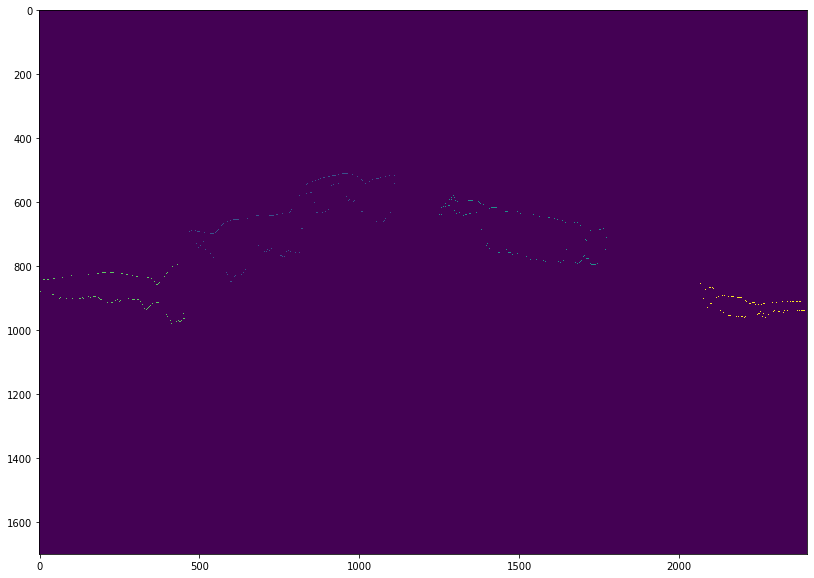

In [26]:
figure(figsize=(20,10))
imshow(edges)

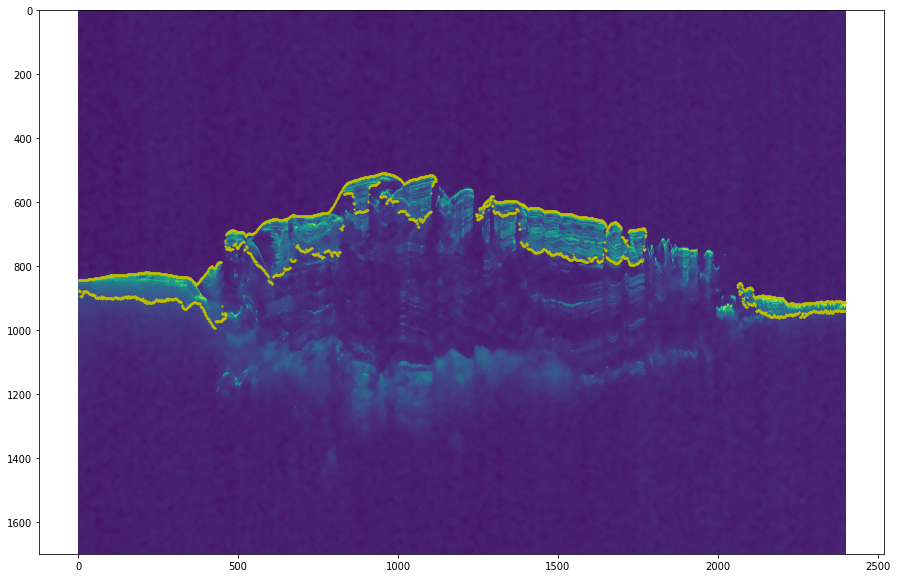

In [27]:
figure(figsize=(20,10))
imshow(imgInTiny)
plt.scatter(upperlimity,upperlimitx, c='y', s=1)
plt.scatter(lowerlimity,lowerlimitx, c='y', s=1)